In [28]:
import numpy
from astropy.io import fits
import os
%matplotlib notebook
from matplotlib import pyplot

In [14]:
from aotools.circle import zernike
from soapy import atmosphere

In [20]:
def getZernCoeffs(
        nZerns, nScrns, scrnSize, subScrnSize, r0, subHarmonics=False):

    Zs = zernike.zernikeArray(nZerns+1, subScrnSize)
    piston = Zs[0]
    Zs = Zs[1:]
    Zs.shape = nZerns, subScrnSize*subScrnSize

    subsPerScrn = scrnSize/subScrnSize
    zCoeffs = numpy.zeros((nZerns, nScrns*(subsPerScrn**2)))

    i = 0
    for n in range(nScrns):
        # Make one big screen
        if subHarmonics:
            scrn = atmosphere.ft_sh_phase_screen(
                    r0, scrnSize, 1./subScrnSize, 100., 0.01)
        else:
            scrn = atmosphere.ft_phase_screen(
                    r0, scrnSize, 1./subScrnSize, 100., 0.01)

        # Pick out as many sub-scrns as possible to actually test
        for x in range(subsPerScrn):
            for y in range(subsPerScrn):
                subScrn = scrn[
                        x*subScrnSize: (x+1)*subScrnSize,
                        y*subScrnSize: (y+1)*subScrnSize]
                subScrn = subScrn.reshape(subScrnSize*subScrnSize)

                # Turn into radians. r0 defined at 500nm, scrns in nm
                # subScrn /= (500/(2*numpy.pi))

                # Dot with zernikes to get powerspec
                zCoeffs[:, i] = (Zs*subScrn).sum(1)/piston.sum()
                i+=1

    return zCoeffs

In [25]:
def testZernSpec(
        nZerns, nScrns, scrnSize, subScrnSize, r0, subHarmonics=False):

    zCoeffs = getZernCoeffs(
            nZerns, nScrns, scrnSize, subScrnSize, r0,
            subHarmonics=subHarmonics)
    zVar = zCoeffs.var(1)

    return zVar

In [33]:
nZerns = 50
nScrns = 1000
r0 = 1
subScrnSize = 256
scrnSize = 1024

# Load the noll reference values
noll = fits.getdata("resources/noll.fits").diagonal()[:nZerns]

In [37]:
zVar = testZernSpec(
            nZerns, nScrns, scrnSize, subScrnSize, r0, subHarmonics=False)

In [38]:
zVar_sh = testZernSpec(
            nZerns, nScrns, scrnSize, subScrnSize, r0, subHarmonics=True)

<IPython.core.display.Javascript object>


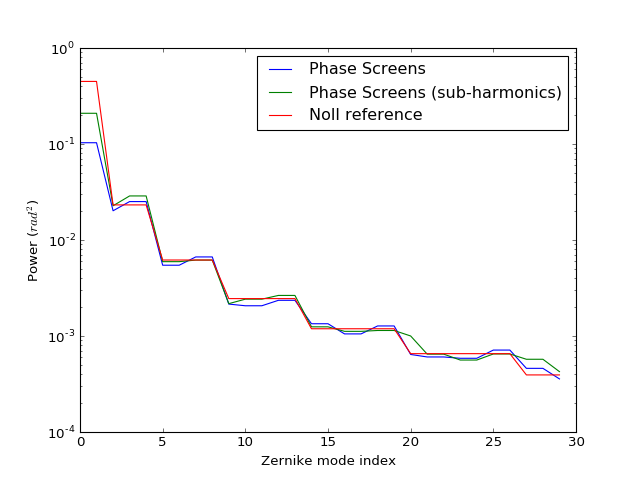

In [39]:
pyplot.figure()
pyplot.semilogy(zVar, label="Phase Screens")
pyplot.semilogy(zVar_sh, label="Phase Screens (sub-harmonics)")
pyplot.semilogy(noll, label="Noll reference")

pyplot.xlabel("Zernike mode index")
pyplot.ylabel("Power ($rad^2$)")

pyplot.legend(loc=0)

pyplot.show()